In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})
# jax.config.update("jax_enable_x64", True)  # 启用 float64 精度


In [12]:
import examples.genes_propagation.configs as cfg
from examples.genes_propagation.model import PINN

cfg = cfg.Config()
pinn = PINN(
    config=cfg,
)

ref_path = cfg.DATA_PATH
mesh_fem = jnp.load(f"{cfg.DATA_PATH}/mesh.npy")
times_fem = jnp.load(f"{cfg.DATA_PATH}/times.npy")
sol = jnp.load(f"{cfg.DATA_PATH}/sol.npy")

mesh = mesh_fem / cfg.Lc
times = times_fem / cfg.Tc

mesh.shape, times.shape, sol.shape

((1001,), (101,), (101, 1001))

In [47]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/genes_prop/irr/baseline-40k/model-40000/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/genes_prop/noirr/baseline-40k/model-40000/")
params = state["params"]
params_noirr = state_noirr["params"]

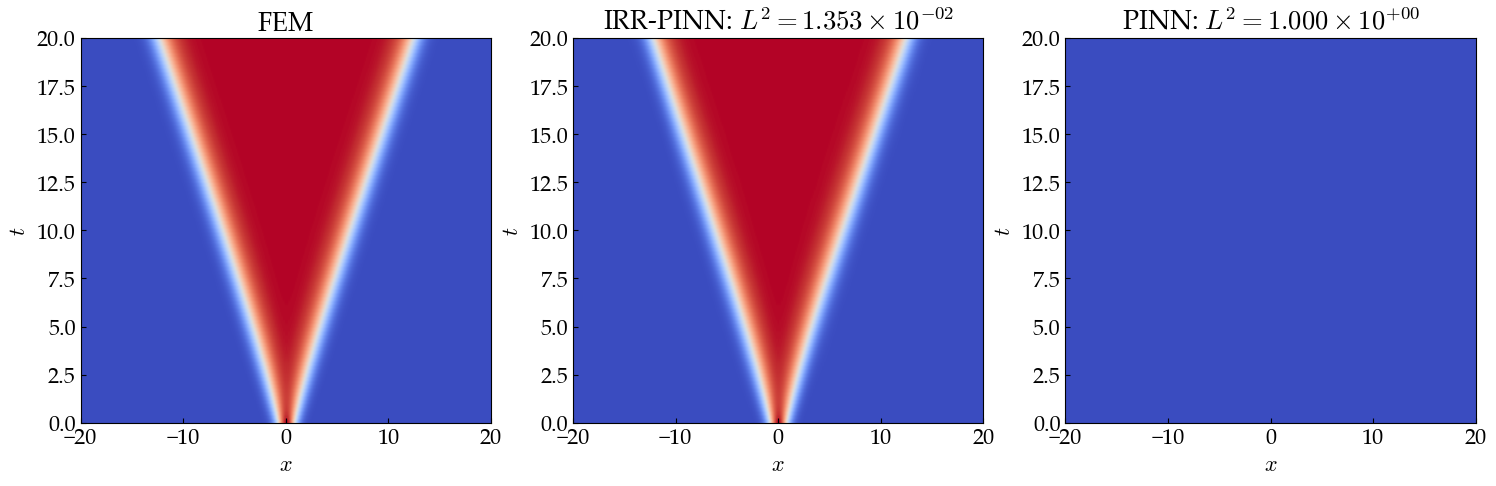

In [58]:
%matplotlib inline
xx, tt = jnp.meshgrid(mesh, times)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax = axes[0]

# plot FEM solution
ax.imshow(
    sol,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title("FEM")

ax = axes[1]
xx_flat = xx.flatten()[:, None]
tt_flat = tt.flatten()[:, None]
pred_flat = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, xx_flat, tt_flat)
pred = pred_flat.reshape(xx.shape)
error = jnp.linalg.norm(pred - sol) / jnp.linalg.norm(sol)
error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
ax.imshow(
    pred,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title(f"IRR-PINN: "+ error_str)

ax = axes[2]
pred_flat_noirr = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params_noirr, xx_flat, tt_flat)
pred_noirr = pred_flat_noirr.reshape(xx.shape)
error_noirr = jnp.linalg.norm(pred_noirr - sol) / jnp.linalg.norm(sol)
error_str_noirr = "$L^2=" + f"{error_noirr:.3e}".replace("e", r"\times 10^{") + "}$"
im = ax.imshow(
    pred_noirr,
    origin="lower",
    aspect="auto",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    extent=[mesh_fem.min(), mesh_fem.max(), times_fem.min(), times_fem.max()]
)
ax.set(xlabel="$x$", ylabel="$t$")
ax.set_title(f"PINN: "+ error_str_noirr) 

fig.savefig("./figures/travelling_wave_sol.png", dpi=300, bbox_inches='tight')
fig.savefig("./figures/travelling_wave_sol.pdf", dpi=300, bbox_inches='tight')


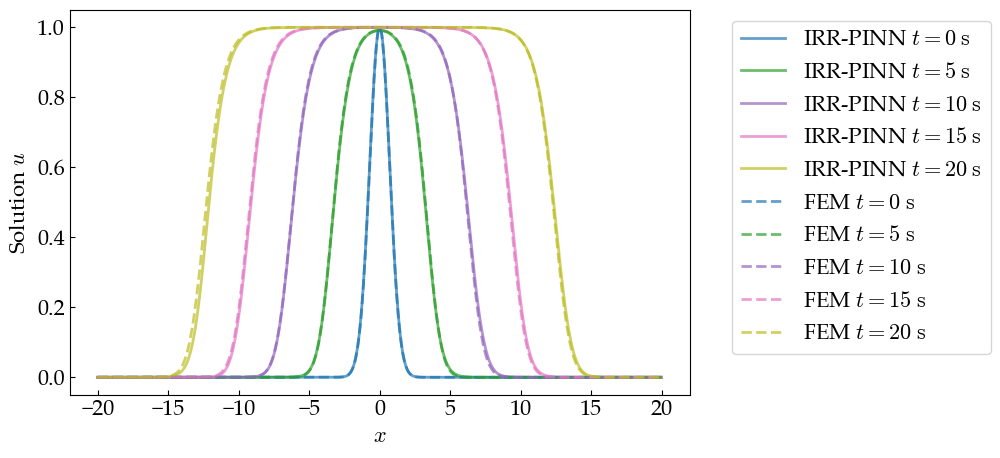

In [59]:
ts = [0.0, 5.0, 10.0, 15.0, 20.0]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, pred[t_idx, :],
        label=f"IRR-PINN " + rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.tab10(idx / len(ts)),
        linestyle="solid",
        linewidth=2,
        alpha=0.7
    )
    
for idx, t in enumerate(ts):
    t_c = t / cfg.Tc
    t_idx = jnp.argmin(jnp.abs(times - t_c))
    ax.plot(
        mesh_fem, sol[t_idx, :],
        label=f"FEM " + rf"$t={int(t)} \;\mathrm{{s}}$",
        color=plt.cm.tab10(idx / len(ts)),
        linestyle="dashed",
        linewidth=2,
        alpha=0.7
    )
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
ax.set(xlabel="$x$", ylabel="Solution $u$")
fig.savefig("./figures/travelling_wave_timesnap.png", dpi=300, bbox_inches='tight')
fig.savefig("./figures/travelling_wave_timesnap.pdf", dpi=300, bbox_inches='tight')

In [60]:
epochs = jnp.arange(0, 40001, 200)
error_log = []
error_log_noirr = []

for epoch in epochs:
    state = ckpt.restore(f"/root/autodl-tmp/tf-logs/genes_prop/irr/baseline-40k/model-{epoch}/")
    state_noirr = ckpt.restore(f"/root/autodl-tmp/tf-logs/genes_prop/noirr/baseline-40k/model-{epoch}/")
    params = state["params"]
    params_noirr = state_noirr["params"]
    pred_flat = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params, xx_flat, tt_flat)
    pred = pred_flat.reshape(xx.shape)
    error = jnp.linalg.norm(pred - sol) / jnp.linalg.norm(sol)
    error_log.append(error)
    
    pred_flat_noirr = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params_noirr, xx_flat, tt_flat)
    pred_noirr = pred_flat_noirr.reshape(xx.shape)
    error_noirr = jnp.linalg.norm(pred_noirr - sol) / jnp.linalg.norm(sol)
    error_log_noirr.append(error_noirr)

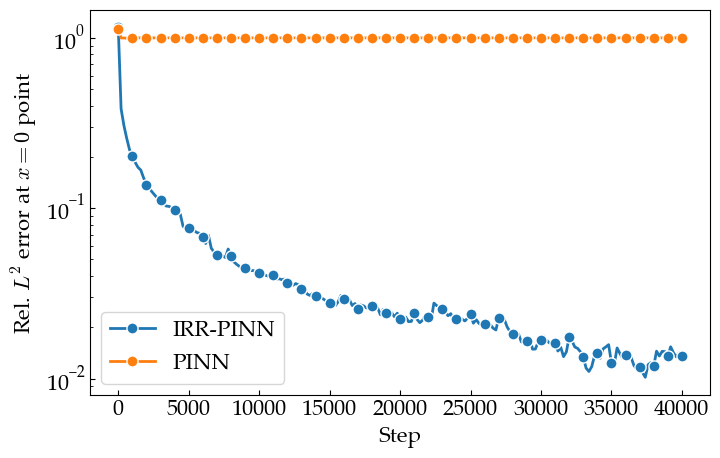

In [65]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(epochs, error_log, label="IRR-PINN", marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2, markevery=5)
ax.plot(epochs, error_log_noirr, label="PINN", marker="o", markeredgecolor="white", markersize=8, markeredgewidth=1, lw=2, markevery=5)

ax.set(ylabel="Rel. $L^2$ error at $x=0$ point",
       xlabel="Step", yscale="log")
ax.legend()
fig.savefig("figures/genes-prop-error-log.png", dpi=300, bbox_inches='tight')
fig.savefig("figures/genes-prop-error-log.pdf", dpi=300, bbox_inches='tight')


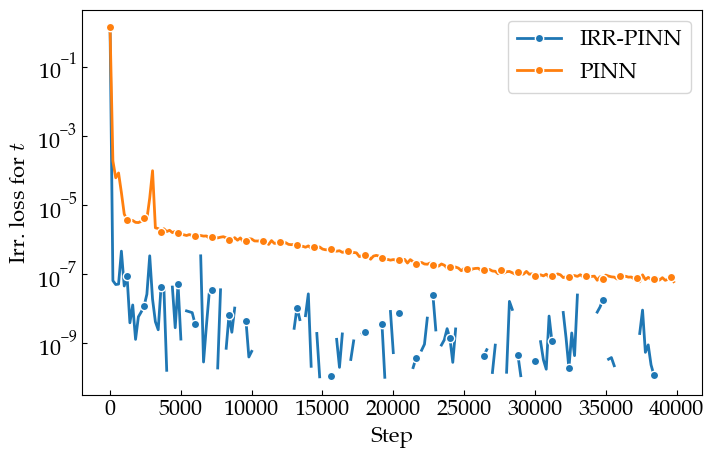

In [67]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-genes_prop_irr_baseline-40k-tag-loss_irr_x.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-genes_prop_noirr_baseline-40k-tag-loss_irr_x.csv")

error_log = error_log[error_log["Step"] < 40000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 40000]

# error_log["Value"][error_log["Value"] < 1e-10] = jnp.nan
# error_log_noirr["Value"][error_log_noirr["Value"] < 1e-10] = jnp.nan
error_log.loc[error_log["Value"] < 1e-10, "Value"] = jnp.nan
error_log_noirr.loc[error_log_noirr["Value"] < 1e-10, "Value"] = jnp.nan
# error_log.dropna(inplace=True, how='any')
# error_log_noirr.dropna(inplace=True, how='any')


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss for $t$", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
fig.savefig("figures/genes-prop-irr-loss-log.png", dpi=300, bbox_inches='tight')
fig.savefig("figures/genes-prop-irr-loss-log.pdf", dpi=300, bbox_inches='tight')

